In [1]:
import numpy as np
import json
import torch
import torch.nn as nn
from networks import SCLIPNN
import clip
from multilingual_clip import pt_multilingual_clip
import transformers
from PIL import Image
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import torchvision.transforms.functional as fn
import pandas as pd
import yaml
import os
from datetime import datetime

In [2]:
#######################################
# Models functions
#######################################
def get_sbert_and_clip_and_mclip_models():
    sbert_model = SentenceTransformer('distiluse-base-multilingual-cased-v1')
    print("SBERT model loaded")
    clip_model, preprocess = clip.load("ViT-B/32", device=device)
    print("CLIP model loaded")
    mclip_model = pt_multilingual_clip.MultilingualCLIP.from_pretrained('M-CLIP/XLM-Roberta-Large-Vit-B-32')
    mclip_tokenizer = transformers.AutoTokenizer.from_pretrained('M-CLIP/XLM-Roberta-Large-Vit-B-32')
    print("MCLIP model loaded")
    return sbert_model.eval(), (clip_model.eval(), preprocess), (mclip_model.eval(), mclip_tokenizer)

def get_sbert_embeddings(sentences, sbert_model):
    with torch.no_grad():  
        sbert_embeddings = torch.from_numpy(sbert_model.encode(sentences))
    return sbert_embeddings

def get_clip_embeddings(sentences, clip_model, batch_size=10):
    tokenized_text = clip.tokenize(sentences).to(device)
    with torch.no_grad():
        clip_embeddings_list = []
        for i in range(0,tokenized_text.size()[0],batch_size):
            tok_batch = tokenized_text[i:i+batch_size]
            clip_embeddings_batch = clip_model.encode_text(tok_batch).to(device)
            for unity in clip_embeddings_batch:
                clip_embeddings_list.append(unity)
    final_emb = torch.stack(clip_embeddings_list)
    return final_emb

def get_mclip_embeddings(sentences, mclip_model, mclip_tokenizer):
    with torch.no_grad():
        mclip_embeddings = mclip_model.forward(sentences, mclip_tokenizer).to(device)
    return mclip_embeddings

def load_model(path_to_model,sbert_model):
    PATH = path_to_model
    sbert_features = get_sbert_embeddings(['simple sentence'],sbert_model)
    input_size = sbert_features.shape[1]
    model = SCLIPNN(input_size,900)
    model.load_state_dict(torch.load(PATH))
    return model

def sbert_to_clip(sbert_features, name_model):
    splitted_name = name_model.split("_")
    hidden_size = int(splitted_name[2])
    input_size = sbert_features.shape[1]
    PATH = os.path.join("models",name_model)
    model = SCLIPNN(input_size,hidden_size)
    model.load_state_dict(torch.load(PATH))
    model.eval()
    output = model(sbert_features)
    return output

def get_logits(image_features, text_features, encoding='sbert'):
    # normalized features
    if text_features.dtype == torch.int64:
        text_features = text_features.type(torch.FloatTensor)
    if text_features.dtype == torch.float32:
        text_features = text_features.to(torch.float16)
    if text_features.dtype == torch.float16:
        text_features = text_features.to(torch.float32)
        
    image_features = (image_features / image_features.norm(dim=-1, keepdim=True)).to(device)
    text_features = (text_features / text_features.norm(dim=-1, keepdim=True)).to(device)

    # cosine similarity as logits
    logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))
    logit_scale = logit_scale.exp().to(device)
    logits_per_image = logit_scale * image_features @ text_features.t()
    logits_per_text = logits_per_image.t()

    # shape = [global_batch_size, global_batch_size]
    return logits_per_image, logits_per_text  

In [3]:
#################################
# Images functions
#################################
def get_image(directory, image_id):
    image = Image.open(os.path.join(directory, image_id))
    return image

def reshape(im):
    print("This is size of original image:",im.size, "\n")
    width, height = im.size
    # print("W: {} and H: {}".format(width, height))
    if width > 1000 or height > 1000:
        scale = 3
    elif width > 500 or height > 500:
        scale = 2
    else:
        scale = 1    
    new_width = int(width / scale)
    new_height = int(height / scale)
    #image = preprocess(im)
    image = fn.resize(im, size=[new_width])
    print("This is size of resized image:",image.size, "\n")
    return image

def get_image_features(images, image_directory, clip_model, preprocess):
    N = len(images)
    count = 0
    image_features = torch.empty(size=(N, 512))
    for i,image_id in enumerate(images):
        count += 1
        im = get_image(image_directory, image_id)
        image = preprocess(im).unsqueeze(0).to(device)
        with torch.no_grad():
            clip_image = clip_model.encode_image(image)
            image_features[i] = clip_image
    return image_features

In [4]:
def get_images_and_captions(languages):
    images_of_language = {}
    captions_of_language = {}
    for lang, code in languages.items():        
        f_json = open(os.path.join(directory, "{}_pairs.json".format(code)), mode='r', encoding='utf-8')
        pairs_data = json.load(f_json)
        images = []
        captions = []
        for pair in pairs_data:
            images.append(pair["image_id"])
            captions.append(pair["caption"])
        images_of_language[lang] = images
        captions_of_language[lang] = captions
    return images_of_language, captions_of_language

In [5]:
def get_image_and_captions_clip_features(languages, image_directory,clip_model, preprocess):
    images, captions = get_images_and_captions(languages)
    images_features = {}
    clip_features = {}
    for lang in languages.keys():
        images_features[lang] = get_image_features(images[lang],image_directory,clip_model, preprocess)
        clip_features[lang] = get_clip_features(captions[lang],clip_model).to(device)
    return images_features, clip_features, captions

In [6]:
#######################################
# Additional Functions
#######################################
def display_results(sbert_lang_performance, clip_lang_performance, sbert_lang_errors, clip_lang_errors, sbert_lang_mrr, clip_lang_mrr):
    results = pd.DataFrame({"SBERT":sbert_lang_performance, "CLIP": clip_lang_performance,
                        "error SBERT":sbert_lang_errors, "error CLIP":clip_lang_errors,
                       "MRR sbert":sbert_lang_mrr, "MRR clip": clip_lang_mrr}, 
                       index=languages)
    print(results)

def show_plot(languages, sbert_lang_mrr, clip_lang_mrr, mclip_lang_mrr):
    X_axis = np.arange(len(languages.keys()))
    figure_name = plt.figure(figsize=(20, 8))
    plt.bar(X_axis-0.2, sbert_lang_mrr, 0.4, color = 'blue', edgecolor = 'black', capsize=7, label='SBERT MRR')
    plt.bar(X_axis+0.2, clip_lang_mrr, 0.4, color = 'red', edgecolor = 'black', capsize=7, label='CLIP MRR')
    plt.bar(X_axis+0.2, mclip_lang_mrr, 0.4, color = 'yellow', edgecolor = 'black', capsize=7, label='CLIP MRR')
    plt.xticks(rotation = 45)
    plt.xticks(X_axis, languages.keys())
    plt.legend()
    plt.show()
    
def reciprocal_rank(probs, value):
    N = len(probs)
    copy_probs = list(probs.copy())
    for i in range(N):
        max_value = max(copy_probs)
        if max_value == value:
            return 1/(i + 1)
        else:
            copy_probs.remove(max_value)
    return 1/N

In [7]:
def get_MRR(languages, name_of_model, sbert_model, clip_model, preprocess, mclip_model, mclip_tokenizer, captions, images_features):
    sbert_lang_performance = []
    clip_lang_performance = []
    mclip_lang_performance = []
    sbert_lang_errors = []
    clip_lang_errors = []
    mclip_lang_errors = []
    sbert_lang_mrr = []
    clip_lang_mrr = []
    mclip_lang_mrr = []
    vetoed = []
    for lang, code in languages.items():
        print("Processing captions in "+ lang +"...")

        with torch.no_grad():
            try:
                torch_features = get_sbert_embeddings(captions[lang],sbert_model) 
                sbert_features = sbert_to_clip(torch_features,name_of_model).type(torch.float16)
                print("SBERT features ready. Timestamp: {}".format(datetime.now()))
                clip_features = get_clip_embeddings(captions[lang],clip_model).to(device)
                print("CLIP features ready. Timestamp: {}".format(datetime.now()))
                mclip_features = get_mclip_embeddings(captions[lang],mclip_model,mclip_tokenizer)
                print("MCLIP features ready. Timestamp: {}".format(datetime.now()))
            except:
                print("Not able to tokenize in {}. Skipping language {}".format(lang, code))
                vetoed.append(lang)
                continue
            
        print("Encodings complete")

        sbert_performance = []
        clip_performance = []
        mclip_performance = []
        sbert_errors = 0
        clip_errors = 0
        mclip_errors = 0
        sbert_rr = 0
        clip_rr = 0
        mclip_rr = 0
        counter = 0
        
        for image_features in images_features:
            # Get the probabilities for SBERT and CLIP
            logits_image_sbert, logits_text_sbert = get_logits(image_features, sbert_features,'sbert')
            logits_image_mclip, logits_text_mclip = get_logits(image_features, mclip_features,'mclip')
            logits_image_clip, logits_text_clip = get_logits(image_features, clip_features,'clip')
            probs_sbert = logits_image_sbert.softmax(dim=-1).cpu().detach().numpy()
            probs_mclip = logits_image_mclip.softmax(dim=-1).cpu().detach().numpy()
            probs_clip = logits_image_clip.softmax(dim=-1).cpu().detach().numpy()
            
            # Append the probs to array            
            ps = probs_sbert[counter]
            sbert_rr += reciprocal_rank(probs_sbert,ps)
            sbert_performance.append(ps)
            if ps < max(probs_sbert):
                sbert_errors += 1
            pc = probs_clip[counter]
            clip_rr += reciprocal_rank(probs_clip,pc)
            clip_performance.append(pc)
            if pc < max(probs_clip):
                clip_errors += 1
            pm = probs_mclip[counter]
            mclip_rr += reciprocal_rank(probs_mclip,pm)
            mclip_performance.append(pm)
            if pm < max(probs_mclip):
                mclip_errors += 1
            counter += 1

            if counter % 100 == 0:
                print("{} images already processed for {}".format(counter,lang))

        print('-'*70)
        # print("Images processed: {}".format(counter))
        # print("Classifications errors: SBERT --> {} ; CLIP --> {}".format(sbert_errors,clip_errors))
        sbert_lang_performance.append(round(sum(sbert_performance)/counter,6))
        clip_lang_performance.append(round(sum(clip_performance)/counter,6))
        mclip_lang_performance.append(round(sum(mclip_performance)/counter,6))
        sbert_lang_mrr.append(round(sbert_rr/counter,4))
        clip_lang_mrr.append(round(clip_rr/counter,4))
        mclip_lang_mrr.append(round(mclip_rr/counter,4))
        sbert_lang_errors.append(sbert_errors)
        clip_lang_errors.append(clip_errors)
        mclip_lang_errors.append(mclip_errors)
    print("Done")
    print("Forbidden Languages: {}".format(vetoed))
    
    return sbert_lang_performance, clip_lang_performance, mclip_lang_performance, sbert_lang_mrr, clip_lang_mrr, mclip_lang_mrr, sbert_lang_errors, clip_lang_errors, mclip_lang_errors

In [8]:
if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    with open(os.path.join("preprocessing", "config.yml"), "r") as ymlfile:
        cfg = yaml.safe_load(ymlfile)
    directory = cfg["coco"]["out_dir"]
    image_directory = cfg["coco"]["image_dir"]
    print("Image_directory: {}".format(image_directory))
    languages = cfg["languages"]
    model_dir = cfg["models"]["model_dir"]
    name_of_model = 'coco_NN_900_e300_s400000.pt'
    trained_model = os.path.join(model_dir,name_of_model)
    print(languages)

Image_directory: /home/users/acordova/project/SCLIP/coco/images/val2017
{'english': 'en', 'spanish': 'es', 'italian': 'it', 'german': 'de', 'french': 'fr'}


In [9]:
sbert_model, (clip_model, preprocess), (mclip_model, mclip_tokenizer) = get_sbert_and_clip_and_mclip_models()

SBERT model loaded
CLIP model loaded


Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


MCLIP model loaded


In [10]:
images, captions = get_images_and_captions(languages)
images_features = get_image_features(images["english"], image_directory, clip_model, preprocess)

In [11]:
sbert_per, clip_per, mclip_per, sbert_MRR, clip_MRR, mclip_MRR, sbert_errors, clip_errors, mclip_errors = get_MRR(languages, trained_model, sbert_model, clip_model, preprocess, mclip_model, mclip_tokenizer, captions, images_features)

Processing captions in english...
SBERT features ready. Timestamp: 2022-12-09 10:42:23.936047
CLIP features ready. Timestamp: 2022-12-09 10:42:25.543090
MCLIP features ready. Timestamp: 2022-12-09 10:46:04.616374
Encodings complete
100 images already processed for english
200 images already processed for english
300 images already processed for english
400 images already processed for english
----------------------------------------------------------------------
Processing captions in spanish...
SBERT features ready. Timestamp: 2022-12-09 10:46:07.393244
CLIP features ready. Timestamp: 2022-12-09 10:46:09.004198
MCLIP features ready. Timestamp: 2022-12-09 10:49:41.820665
Encodings complete
100 images already processed for spanish
200 images already processed for spanish
300 images already processed for spanish
400 images already processed for spanish
----------------------------------------------------------------------
Processing captions in italian...
SBERT features ready. Timestamp:

In [12]:
display_results(sbert_per,clip_per,sbert_errors, clip_errors,sbert_MRR,clip_MRR)

            SBERT      CLIP  error SBERT  error CLIP  MRR sbert  MRR clip
english  0.010901  0.015532          271         220     0.5242    0.6257
spanish  0.009957  0.006618          295         327     0.4793    0.3837
italian  0.009801  0.005680          303         363     0.4622    0.3070
german   0.010233  0.005519          293         352     0.4822    0.3197
french   0.010251  0.007009          297         326     0.4791    0.3894


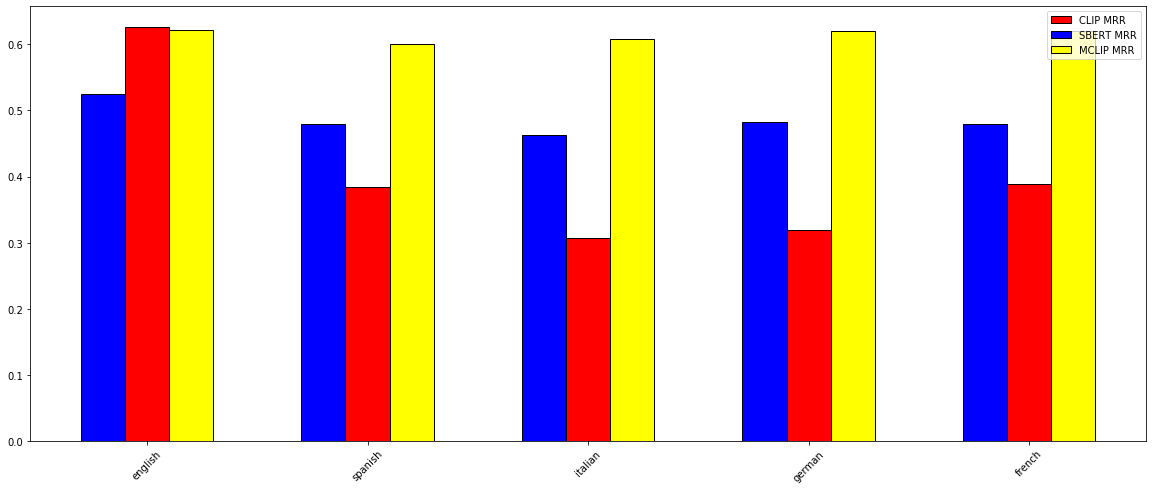

In [14]:
X_axis = np.arange(len(languages.keys()))
figure_name = plt.figure(figsize=(20, 8))
plt.bar(X_axis-0.0, clip_MRR, 0.2, color = 'red', edgecolor = 'black', capsize=7, label='CLIP MRR')
plt.bar(X_axis-0.2, sbert_MRR, 0.2, color = 'blue', edgecolor = 'black', capsize=7, label='SBERT MRR')
plt.bar(X_axis+0.2, mclip_MRR, 0.2, color = 'yellow', edgecolor = 'black', capsize=7, label='MCLIP MRR')
plt.xticks(rotation = 45)
plt.xticks(X_axis, languages.keys())
plt.legend()
plt.show()